This is a tutorial blog post demonstrating some of the options the RDKit has for highlighting parts of molecules to show additional information.

An older blog post shows a more advanced application: using multiple highlights together with R-group decomposition: https://greglandrum.github.io/rdkit-blog/posts/2021-08-07-rgd-and-highlighting.html


In [1]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import SimilarityMaps
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdDepictor
rdDepictor.SetPreferCoordGen(True)

import rdkit
print(rdkit.__version__)

2024.09.5


Test molecule:

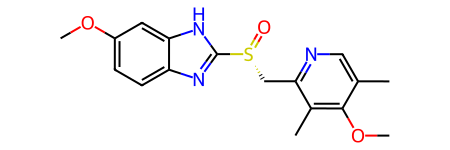

In [2]:
esomep = Chem.MolFromSmiles('COc1ccc2nc([nH]c2c1)[S@](=O)Cc1ncc(C)c(OC)c1C')
rdDepictor.Compute2DCoords(esomep)
esomep

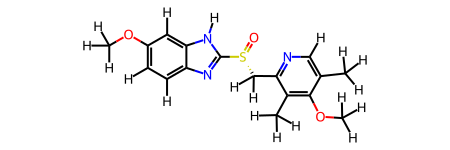

In [3]:
esomep_h = Chem.AddHs(esomep)
rdDepictor.Compute2DCoords(esomep_h)
esomep_h

# Highlight numerical data

As an example of numeric data I'll use partial charges calculated using the DASH-props tree populated with AM1-BCC charges.
Here's the paper describing the work: https://doi.org/10.1063/5.0218154
and here's the github repo: https://github.com/rinikerlab/DASH-tree

In [4]:
from serenityff.charge.tree.dash_tree import DASHTree, TreeType
from serenityff.charge.data import dash_props_tree_path
tree = DASHTree(tree_folder_path=dash_props_tree_path, tree_type=TreeType.FULL)

Loading DASH tree data
Loaded 122 trees and data


In [5]:
charges = tree.get_molecules_partial_charges(esomep_h, chg_key="AM1BCC", 
                                              chg_std_key="AM1BCC_std")["charges"]

charges[:6]

[0.10260369084159895,
 -0.3260823673748836,
 0.13600369084159897,
 -0.17074237544369403,
 -0.04009630915840103,
 0.009303690841598967]

Let's start with the oldest option in the RDKit and the one that is best suited to presenting continuous numerical data, similarity maps:

In [6]:
from IPython.display import SVG

d2d = Draw.MolDraw2DSVG(550,350)
dopts = d2d.drawOptions()
dopts.useBWAtomPalette()
SimilarityMaps.GetSimilarityMapFromWeights(esomep_h,charges,d2d,colorMap='coolwarm',alpha=0)
d2d.FinishDrawing()
SVG(d2d.GetDrawingText())

Notice above that I switched to using a black and white atom palette when doing highlighting. I think this makes everything easier to read and will do it throughout this post.

In [7]:
max(charges),min(charges)

(0.44457, -0.6342717064338059)

An alternate approach: draw the molecule and use distinct atomic highlights (circles/ovals) with a radius proportional to the magnitude of the charge.

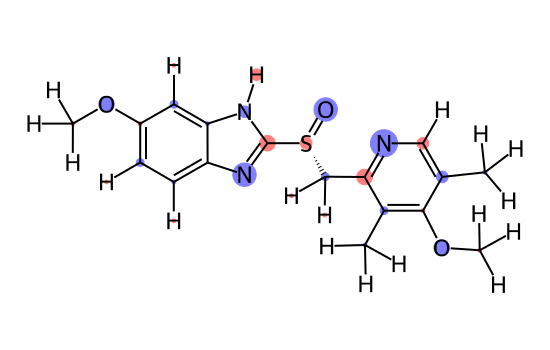

In [8]:
maxRad = 0.5
chargeRadii = {}
chargeColors = {}
highlightAtoms = []
for i,chg in enumerate(charges):
    # quantize and scale the charge so that we can use it to scale the highlight radii
    chg = (10*chg//1)/10
    if abs(chg)>1e-4:
        chargeRadii[i] = abs(chg)*maxRad 
        highlightAtoms.append(i)
        if chg>0:
            chargeColors[i] = (1,.5,.5)
        else:
            chargeColors[i] = (.5,.5,1)

d2d = Draw.MolDraw2DSVG(550,350)
dopts = d2d.drawOptions()
dopts.useBWAtomPalette()
# we need to set the highlights to be circles or we'll end up with ovals
# that fit around the atomic symbol
dopts.atomHighlightsAreCircles = True

# we need to provide highlightBonds=[] here to avoid having the bonds between highlighted atoms highlighted:
d2d.DrawMolecule(esomep_h,highlightAtoms=highlightAtoms,highlightAtomColors=chargeColors,highlightAtomRadii=chargeRadii,
                highlightBonds=[])
d2d.FinishDrawing()
SVG(d2d.GetDrawingText())

We can also add the numeric values for the atoms where we've drawn circles by setting the `atomNote` property on those atoms:

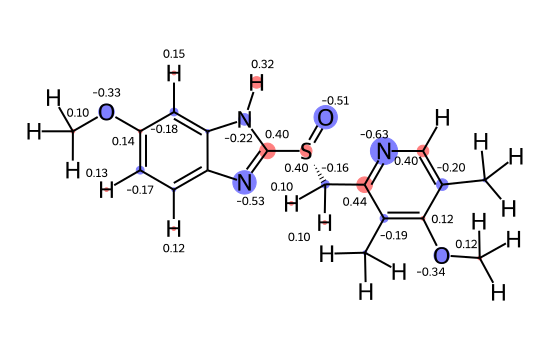

In [9]:
molcopy = Chem.Mol(esomep_h)

for aid in chargeColors:
    chg = charges[aid]
    if abs(chg)>=0.1:
        molcopy.GetAtomWithIdx(aid).SetProp('atomNote',f'{charges[aid]:.2f}')
d2d = Draw.MolDraw2DSVG(550,350)
dopts = d2d.drawOptions()
dopts.useBWAtomPalette()
dopts.atomHighlightsAreCircles = True
d2d.DrawMolecule(molcopy,highlightAtoms=highlightAtoms,highlightAtomColors=chargeColors,highlightAtomRadii=chargeRadii,
                highlightBonds=[])
d2d.FinishDrawing()
SVG(d2d.GetDrawingText())

# Highlighting regions of a molecule

## Single color

This time we're going to highlight regions of the molecule that match a substructure

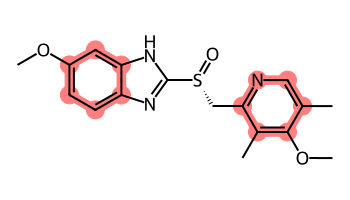

In [10]:
# build a list that has all atoms that match the substructure:
matches1 = esomep.GetSubstructMatches(Chem.MolFromSmarts('a1aaaaa1'))
highlightAtoms = []
for match in matches1:
    highlightAtoms.extend(match)

# and now draw with highlights on those atoms:    
d2d = Draw.MolDraw2DSVG(350,200)
dopts = d2d.drawOptions()
dopts.useBWAtomPalette()
d2d.DrawMolecule(esomep,highlightAtoms=highlightAtoms)
d2d.FinishDrawing()
SVG(d2d.GetDrawingText())


## Multiple colors

We can also have multiple different highlighting colors.

In [11]:
# rather than trying to guess discernible colors, I will just use 
# matplotlib's color scheme
import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')
from matplotlib import colors

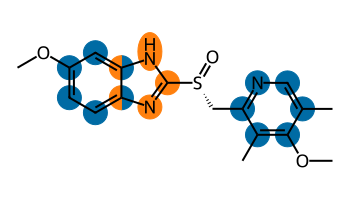

In [12]:
from collections import defaultdict

matches1 = esomep.GetSubstructMatches(Chem.MolFromSmarts('a1aaaaa1'))
color1 = colors.to_rgb('C0')
matches2 = esomep.GetSubstructMatches(Chem.MolFromSmarts('a1aaaa1'))
color2 = colors.to_rgb('C1')

rad = 0.4
atomHighlights = defaultdict(list)
atomRads = {}
for (matches,color) in zip((matches1,matches2),(color1,color2)):
    for match in matches:
        for aid in match:
            atomHighlights[aid].append(color)
            atomRads[aid] = rad
        
d2d = Draw.MolDraw2DSVG(350,200)
dopts = d2d.drawOptions()
dopts.useBWAtomPalette()
d2d.DrawMoleculeWithHighlights(esomep,"",dict(atomHighlights),{},atomRads,{})
d2d.FinishDrawing()
SVG(d2d.GetDrawingText())

We can also just draw the outlines of the highlighted atoms:

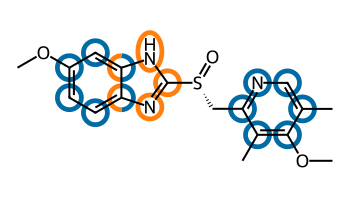

In [13]:
d2d = Draw.MolDraw2DSVG(350,200)
dopts = d2d.drawOptions()
dopts.useBWAtomPalette()
dopts.fillHighlights = False
d2d.DrawMoleculeWithHighlights(esomep,"",dict(atomHighlights),{},atomRads,{})
d2d.FinishDrawing()
SVG(d2d.GetDrawingText())

Repeat that, but include the bonds as well.

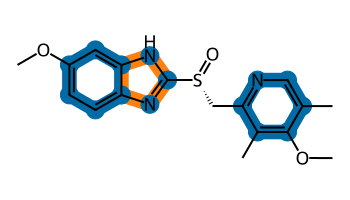

In [14]:
rad = 0.3
atomHighlights = defaultdict(list)
bondHighlights = defaultdict(list)
atomRads = {}

for (matches,color) in zip((matches1,matches2),(color1,color2)):
    for match in matches:
        for i,aid in enumerate(match):
            atomHighlights[aid].append(color1)
            atomRads[aid] = rad
            bnd = esomep.GetBondBetweenAtoms(aid,match[(i+1)%len(match)])
            bondHighlights[bnd.GetIdx()].append(color)
        
d2d = Draw.MolDraw2DSVG(350,200)
dopts = d2d.drawOptions()
dopts.useBWAtomPalette()
# I think this looks better if we ensure that the atom highlights are always circles:
dopts.atomHighlightsAreCircles = True
d2d.DrawMoleculeWithHighlights(esomep,"",dict(atomHighlights),dict(bondHighlights),atomRads,{})
d2d.FinishDrawing()
SVG(d2d.GetDrawingText())

We can also do that in a more "subway map" style. I will add a third highlight to make it more dramatic.

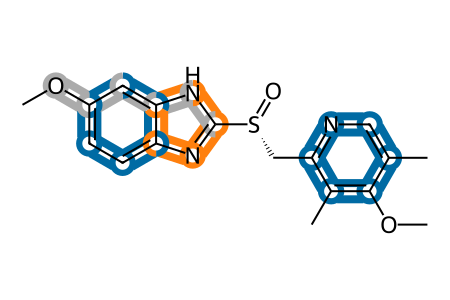

In [15]:
from collections import defaultdict

matches1 = esomep.GetSubstructMatches(Chem.MolFromSmarts('a1aaaaa1'))
color1 = colors.to_rgb('C0')
matches2 = esomep.GetSubstructMatches(Chem.MolFromSmarts('a1aaaa1'))
color2 = colors.to_rgb('C1')
matches3 = esomep.GetSubstructMatches(Chem.MolFromSmarts('Occc[nH]c'))
color3 = colors.to_rgb('C2')

rad = 0.2
atomHighlights = defaultdict(list)
bondHighlights = defaultdict(list)
atomRads = {}
for matches,color in zip((matches1,matches2,matches3),(color1,color2,color3)):
    for match in matches:
        for i,aid in enumerate(match):
            atomHighlights[aid].append(color)
            atomRads[aid] = rad
            bnd = esomep.GetBondBetweenAtoms(aid,match[(i+1)%len(match)])
            if bnd is not None:
                bondHighlights[bnd.GetIdx()].append(color)
        
d2d = Draw.MolDraw2DSVG(450,300)
dopts = d2d.drawOptions()
dopts.useBWAtomPalette()
# turn off the highlight fill and ensure circular atom highlights:
dopts.fillHighlights = False
dopts.atomHighlightsAreCircles = True
d2d.DrawMoleculeWithHighlights(esomep,"",dict(atomHighlights),dict(bondHighlights),atomRads,{})
d2d.FinishDrawing()
SVG(d2d.GetDrawingText())

# Highlighting rings

This is something I first figured out how to do for the [R-group decomposition blog post](https://greglandrum.github.io/rdkit-blog/posts/2021-08-07-rgd-and-highlighting.html) mentioned above.

Here we have to draw the molecule twice: The first time finalizes the scaling of the drawing canvas, then we clear the canvas, draw the polygons that fill the rings, and then draw the molecule a second time on top of the polygons.

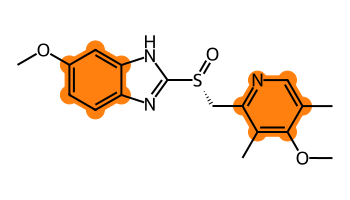

In [16]:
from rdkit import Geometry

# setup the same way we did before:
matches1 = esomep.GetSubstructMatches(Chem.MolFromSmarts('a1aaaaa1'))

color1 = colors.to_rgb('C1')


highlightAtoms = []
for match in matches1:
    highlightAtoms.extend(match)

d2d = Draw.MolDraw2DSVG(350,200)
dopts = d2d.drawOptions()
dopts.useBWAtomPalette()
dopts.setHighlightColour(color1)

# draw the molecule to get the atom drawing positions and set the canvas scale:
d2d.DrawMolecule(esomep,highlightAtoms=highlightAtoms)
d2d.ClearDrawing()

# draw the filled rings:
conf = esomep.GetConformer()
for ring in matches1:
    ps = [Geometry.Point2D(conf.GetAtomPosition(aidx)) for aidx in ring]
    d2d.SetFillPolys(True)
    d2d.SetColour(color1)
    d2d.DrawPolygon(ps)
dopts.clearBackground = False

# now redraw the molecule on top of those ring highlights:
d2d.DrawMolecule(esomep,highlightAtoms=highlightAtoms)
d2d.FinishDrawing()
SVG(d2d.GetDrawingText())


As usual, I hope this was useful. Please leave questions, comments, or suggestions in the widget below.